In [1]:
import pandas as pd
import numpy as np
import neptune.new as neptune
import psutil
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE

np.random.seed(0)
standardizer=StandardScaler()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = pd.read_csv(os.path.join('data','train_data.csv'), header=None)
y = pd.read_csv(os.path.join('data','train_labels.csv'), header=None, names=['y'])

In [3]:
y=np.ravel(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
def get_confusion_matrix(classifier):

    m = classifier.fit(X, y)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    print(confusion_matrix(y_test, y_pred))

LogisticRegression 0.7956149576655805
[[ 20 102]
 [143 860]]
KNeighborsClassifier 0.949668992580465
[[ 91  31]
 [ 25 978]]
SVC 0.9539267661631968
[[102  20]
 [ 33 970]]
AdaBoostClassifier 0.9407824512727929
[[ 83  39]
 [ 26 977]]
OneClassSVM 0.5762279967887776
[[ 52  70]
 [512 491]]
RandomForestClassifier 0.8404419381787802
[[   0  122]
 [   0 1003]]
GradientBoostingClassifier 0.9643584417488882
[[104  18]
 [ 27 976]]


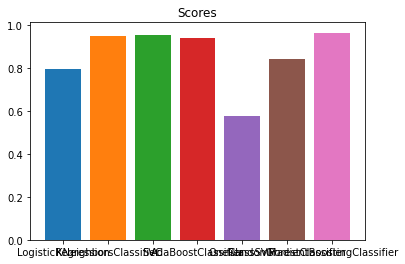

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import OneClassSVM
log_clf = LogisticRegression(random_state=0, max_iter = 1000)
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
abc_clf = AdaBoostClassifier()
oc_clf = OneClassSVM()
rfc_clf = RandomForestClassifier()
gbc_clf = GradientBoostingClassifier()

clf_list = [log_clf, knn_clf, svm_clf, abc_clf, oc_clf, rfc_clf, gbc_clf]

def clf_scores(list):
    for clf in list:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        clf_score = f1_score(y_test, y_pred, average='weighted')
        print(clf.__class__.__name__, clf_score)
        get_confusion_matrix(clf)


        plt.title('Scores')
        plt.bar(clf.__class__.__name__, clf_score);

clf_scores(clf_list)

In [7]:
def run_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)
def train_and_predict(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred,average='weighted')

In [8]:
pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('model', LogisticRegression())
])

train_and_predict(pipeline, X_train, y_train)

c:\users\jakub\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8404419381787802

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=2019)),
    ('rf', RandomForestClassifier(max_depth=5, n_estimators=20, random_state=2019)),
    ('GBC', GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=2019)),
]

for model_name, model in models:
    model.fit(X, y)
    y_pred = model.predict(X)
    score = f1_score(y, y_pred, average='macro')
    
    print(model_name, score)

dt 0.941317263697903
rf 0.4736842105263158
GBC 0.87459200599283


In [12]:
avg=['micro', 'macro','weighted', None]
def train_and_predict_f1(model, X_train, y_train):
    for x in avg:
        model.fit(X_train, y_train)
        y_pred = model.predict(X)
        y_pred[ y_pred < 0 ] =0
        print(f1_score(y, y_pred, average=x, zero_division=1))

pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', MinMaxScaler()),
    ('variance-treshold', VarianceThreshold(threshold=0.05)),
    ('model', RandomForestClassifier(max_depth=5, n_estimators=10))
])

train_and_predict_f1(pipeline, X_train, y_train)

ValueError: No feature in X meets the variance threshold 0.05000

In [13]:
def objective(space):
    
    lg_params = {
        'penalty': space['penalty'],
        'solver': space['solver']
    }
    
    model = LogisticRegression(**lg_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
penalty=list['l1','l2','elasticnet',None]
space ={
    'penalty': hp.choice ('x_penalty', ['l2','none']),
    'solver': hp.choice ('x_solver', ['newton-cg', 'lbfgs', 'saga'])
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=3,
            trials=trials)

print("The best params: ", best_params)

100%|██████████████| 3/3 [00:54<00:00, 18.30s/trial, best loss: 0.7795555555555556]
The best params:  {'x_penalty': 1, 'x_solver': 0}


In [14]:
trials.best_trial

{'state': 2,
 'tid': 2,
 'spec': None,
 'result': {'loss': 0.7795555555555556, 'status': 'ok'},
 'misc': {'tid': 2,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_penalty': [2], 'x_solver': [2]},
  'vals': {'x_penalty': [1], 'x_solver': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 6, 30, 17, 54, 11, 301000),
 'refresh_time': datetime.datetime(2021, 6, 30, 17, 54, 22, 99000)}

In [15]:
pipe = Pipeline(steps=[('prep', StandardScaler()), ('prep2', PCA()), ('classifier', SVC())])

In [16]:
model = LogisticRegression(penalty='none',solver='newton-cg',max_iter=4100,multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted', zero_division=1)
score

0.7944522323872079

In [17]:
def objective(space):
    
    gbc_params = {
        'n_estimators': int(space['n_estimators']),
        'max_depth': int(space['max_depth']),
        'max_features': space['max_features']
    }
    
    model = GradientBoostingClassifier(**gbc_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = f1_score(y_test, y_pred, average='weighted')
    
    return{'loss':score, 'status': STATUS_OK }
space ={'n_estimators': hp.quniform ('x_n_estimators', 100, 500, 100),
        'max_depth': hp.quniform ('x_max_depth', 3, 10, 1),
        'max_features': hp.choice ('x_max_features', ['auto', 'sqrt', 'log2'])
}


trials = Trials()
best_params_gbc = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=3,
            trials=trials)

print("The best params: ", best_params_gbc)

100%|██████████████| 3/3 [02:34<00:00, 51.49s/trial, best loss: 0.8404419381787802]
The best params:  {'x_max_depth': 10.0, 'x_max_features': 1, 'x_n_estimators': 300.0}


In [18]:
def objective(space):
    
    rfc_params = {
        'n_estimators': int(space['n_estimators']),
        'criterion': space['criterion'],
        'max_features': space['max_features']
    }
    
    model = RandomForestClassifier(**rfc_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    
    return{'loss':score, 'status': STATUS_OK }
space ={'n_estimators': hp.quniform ('x_n_estimators', 200, 500, 100),
        'criterion': hp.choice ('x_criterion', ['gini', 'entropy']),
        'max_features': hp.choice ('x_max_features', ['auto', 'sqrt', 'log2'])
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=3,
            trials=trials)

print("The best params: ", best_params)

100%|█████████████| 3/3 [12:23<00:00, 247.92s/trial, best loss: 0.8404419381787802]
The best params:  {'x_criterion': 0, 'x_max_features': 1, 'x_n_estimators': 300.0}
